In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 160975 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.24-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.24-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [5]:
!mkdir -p drive
!google-drive-ocamlfuse drive # 此时colab中出现drive的文件夹，里面就是你的google drive的根目录文件

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [7]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import json

In [8]:
pip install netCDF4

     |████████████████████████████████| 4.7MB 5.1MB/s 
     |████████████████████████████████| 317kB 36.5MB/s 


In [17]:
import os
import netCDF4 as nc4
# print(os.getcwd())
# print(os.path.abspath('.'))

from queue import Queue,LifoQueue,PriorityQueue

drive/resources_EA/Ensemble1/Ensemble1Timestep01.png
Timestep 1 eddy centers


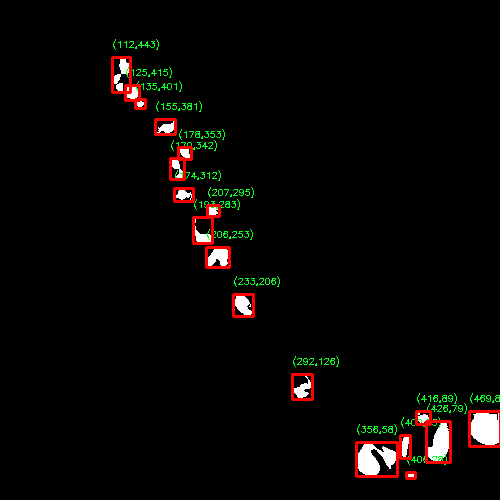

In [16]:
""" Loading Images of eddies and object detection using contours
 Drawring Bounding rectangle around eddies and getting centroid of eddies"""
path = 'drive/resources_EA/Ensemble1/'
timestep = "01"
filename = path+'Ensemble1Timestep'+str(timestep)+'.png'
image = cv2.imread(filename, cv2.IMREAD_COLOR)
print(filename)
# print(image)

copy = image.copy()
gray = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

ROI_number = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)  # x,y表示左上角坐标，w,h表示矩形边框宽度高度
    ROI = image[y:y+h, x:x+w]
    #cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
    cv2.rectangle(copy,(x,y),(x+w,y+h),(0,0,255),2)
    # 注意！在图中显示的是左上角坐标。而下方追踪的时候，是计算好了中心坐标。
    cv2.putText(copy, "("+str(x)+","+str(500-y)+")", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 1)
    
    ROI_number += 1

print("Timestep 1 eddy centers")
cv2_imshow(copy)



In [11]:
# 载入涡旋表层方向nc文件
f = nc4.Dataset('drive/resources_EA/circ1.nc','r', format='NETCDF4')  # 'r' stands for read
print(f.variables['circ'])  # time, latitude, longitude
circ = f.variables['circ'][:, :, :].transpose(0,2,1)  # 时间 经度 纬度



<class 'netCDF4._netCDF4.Variable'>
int16 circ(time, latitude, longitude)
unlimited dimensions: 
current shape = (60, 500, 500)
filling on, default _FillValue of -32767 used


In [38]:
"""Generating feature list like centroid, shape , area for each detected eddy
 to compare it with same eddy in next timestamp. """
cap = cv2.VideoCapture("drive/resources_EA/Ensemble1/Ensemble1Timestep%02d.png",cv2.CAP_IMAGES)

limit = 0  # 处理图片的数量
# time - index of contour - [centroid(x,y),contou rs]
eddy_features = []
aux_features = []  # @自定义
while cap.isOpened() and limit < 30 :
    limit +=1 
    circ_curDay = circ[limit-1]
    ret, frame = cap.read()
    # print(frame.shape)  # 500*500
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    features = []  # features是当天所有涡旋的特征数组组成的数组
    auxf = []  # @自定义 当天所有涡旋特征数组的数组。 特征包含（cx cy area bx by pre next）
    cnts = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1 )
    
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    # print(len(cnts))  # 当天涡旋的数量
    for c in cnts:  # 对于每个涡旋
      M = cv2.moments(c)  # 图像的矩可以帮助我们计算图像的质心，面积等
      #print(M['m00'])
      x,y,w,h = cv2.boundingRect(c)
      cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),1)
      
      if(M['m00'] != 0 ):
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        # 如果当前中心的circ值为0，BFS搜索最近不为零的
        tempCirc = circ_curDay[cx][500-cy];
        # print(tempCirc)
        q = Queue(maxsize=0)
        tempx = cx
        tempy = cy
        q.put([cx, cy])
        while(tempCirc==0):
            newxy = q.get()
            tempx = newxy[0]
            tempy = newxy[1]
            tempCirc = circ_curDay[tempx][500-newxy[1]]
            
            q.put([tempx+1, tempy])
            q.put([tempx-1, tempy])
            q.put([tempx, tempy+1])
            q.put([tempx, tempy-1])
        
        tempCirc = int(tempCirc)  # np.int转int
        # 轮廓的面积可以使用函数cv2.contourArea() 计算得到
        features.append([cx,cy,cv2.contourArea(c)])  # 中心坐标、轮廓面积
        # 这里y要变成500- 是镜像反转。在这里y是向下延伸，而three.js里y是向上
        auxf.append([cx, 500-cy, cv2.contourArea(c), x, 500-y, max(w, h)/2, tempCirc])  # cx cy area bx by r circ
        # print(str(tempx)+","+str(500-tempy), end =" ")
        # print(circ_curDay[tempx][500-tempy])
      # cv2.putText(frame, str(cx)+","+str(cy), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 2)
    eddy_features.append(features)
    aux_features.append(auxf)

    # print()
    
    if cv2.waitKey(50) & 0xFF == ord('q'):
        break

# eddy_features (天数，当天涡旋下标，[涡旋中心cx，涡旋中心cy，涡旋面积])
# for ef in eddy_features:
#   print(ef)

for au in aux_features:
  print(au)

[[410, 26, 22.0, 406, 28, 4.5, -1], [373, 41, 712.5, 356, 58, 20.5, -1], [404, 55, 112.0, 400, 65, 11.5, 1], [439, 57, 554.0, 426, 79, 20.5, -1], [485, 72, 783.5, 469, 89, 17.5, 1], [422, 83, 73.0, 416, 89, 7.0, 1], [301, 111, 160.5, 292, 126, 12.5, 1], [242, 196, 226.0, 233, 206, 11.0, 1], [218, 244, 255.5, 207, 253, 11.0, 1], [201, 265, 138.5, 193, 283, 13.0, -1], [212, 290, 86.0, 207, 295, 6.0, 1], [182, 307, 96.0, 174, 312, 9.5, -1], [175, 334, 110.0, 170, 342, 10.5, -1], [184, 348, 79.0, 178, 353, 6.5, 1], [166, 373, 115.5, 155, 381, 10.0, 1], [139, 397, 42.0, 136, 401, 4.5, -1], [131, 409, 149.0, 125, 415, 7.5, 1], [121, 428, 214.0, 112, 443, 17.5, -1]]
[[373, 42, 729.0, 356, 58, 20.0, -1], [404, 57, 113.0, 399, 66, 10.5, 1], [440, 57, 580.5, 425, 80, 21.5, -1], [486, 71, 693.5, 472, 88, 16.5, 1], [301, 111, 135.5, 293, 119, 9.0, 1], [242, 196, 173.5, 235, 206, 10.5, 1], [219, 244, 222.0, 206, 253, 12.0, 1], [227, 275, 9.5, 224, 276, 3.5, 1], [200, 269, 240.0, 191, 279, 10.5, -1]

In [39]:
""" Generating graph of eddies by treating nodes as eddy center and there is edge between nodes if 
 if they are same eddies """
graph  = []
graph2 = []  # 后向数组
for centroid_list in eddy_features:  # centroid_list是当天的所有涡旋
  l=[[] for i in range(len(centroid_list))]  # len(centroid_list)表示当天涡旋个数
  graph.append(l)
  # 这里不能用graph2.append(l)，因为相同引用会导致graph2和graph一样而出错。。。
  l2=[[] for i in range(len(centroid_list))]  # len(centroid_list)表示当天涡旋个数
  graph2.append(l2)
thresh = 15

for i in range(len(graph)):  # len(graph)表示天数
  for j in range(len(graph[i])):  # len(graph[i])表示第i天涡旋的个数
    if i+1 < len(graph):
      curr = np.array(eddy_features[i][j][0:2])
      curr_area = eddy_features[i][j][2]  # 涡旋轮廓面积
      for  k in range(len(graph[i+1])):  # 对于第i+1天的每个涡旋
        
        nxt = np.array(eddy_features[i+1][k][0:2])
        nxt_area = eddy_features[i+1][k][2]
        
        
        #print((i,j,k),matching_shape)
        # 满足某些条件，可认为k是当前涡旋j的延续
        if np.linalg.norm(curr-nxt) <= thresh and abs(nxt_area - curr_area) <= 200.0  :
          # print(i,"->", i+1,": ", j,"->", k)
          graph[i][j].append(k)
          graph2[i+1][k].append(j)  # 当前涡旋j是下一天涡旋k的前身

# print("Eddies related to first timestep nodes")
# print(graph[0])

for g in graph:
  print(g)

print()

for g2 in graph2:
  print(g2)



[[], [0], [1], [2], [3], [], [4], [5], [6], [8], [9], [10], [11], [12, 13], [14], [16, 17], [16, 17], [18]]
[[1], [2], [3], [5], [7], [9], [10], [12], [11], [12, 13], [14], [15], [], [], [17], [18], [19], [19, 20], [21]]
[[0], [1], [2], [4], [3], [5], [], [], [], [], [6], [7], [8], [8], [9, 10], [], [11], [13], [14], [15, 16], [15, 16], [17]]
[[0], [1], [3], [], [2], [4], [7], [8], [9], [], [10], [13], [14], [16], [17], [18, 19, 20], [19, 20], [21]]
[[0], [1], [], [], [3], [5], [], [], [7], [8], [9, 10], [], [], [11], [12], [13], [14], [15], [], [17, 18], [17, 18], [19]]
[[], [0], [1], [3], [2], [4], [], [7], [8, 9], [10, 11], [10, 11], [13], [14], [15], [16], [17], [], [18, 19], [18, 19], [20]]
[[1], [3], [], [4], [5], [7], [], [9], [10], [10], [11, 12], [12], [13], [14], [15], [], [16], [], [18], [18], [20]]
[[0], [1], [2], [3], [4], [5], [], [7], [8], [9], [10], [11, 12], [11, 12], [13, 14], [15], [16], [17], [18], [19], [], [20]]
[[0], [2], [4], [5], [6], [7], [8], [9], [10], [], [

In [ ]:
import networkx as nx
points_pos={}
nx_graph = nx.Graph()

for i in range(len(graph)):
  for j in range(len(graph[i])):
    nx_graph.add_node(f'({i},{j})')
    points_pos[f'({i},{j})']=  (i,j)

for i in range(len(graph)):
  for j in range(len(graph[i])):
    for adj in graph[i][j]:
      name1 = f"({i},{j})"
      name2 = f"({i+1},{adj})"
      nx_graph.add_edge(name1,name2)


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
nx.draw(nx_graph, with_labels=True, pos=points_pos)
plt.xlabel("Timestep")
plt.show()

fig.savefig('eddy_life_cycle.png')

In [40]:
'''
  生成涡旋json
'''
tarDir = 'features'
if not os.path.exists(tarDir):
  os.makedirs(tarDir)
#这个是简单的涡旋追踪，是生成json后在js里加载的
# feature_dict = {"info": aux_features, "forward": graph, "backward": graph2}
feature_dict = {"info": aux_features, "forward": graph, "backward": graph2}
# 写入时间和索引json数据
feature_json = json.dumps(feature_dict, sort_keys=False)
f = open(os.path.join(tarDir, 'features.json'), 'w')
f.write(feature_json)

21745

In [ ]:
"""
Generating stastics like deaths/births and splits / merges using graph traversal algorithms like
DFS and BFS 
"""

#Life Span Distribution (# Eddies vs eddy life in days)
# Radii distribuition 

deaths = []
births =[]
splits=[]
# Eddy deaths
limiting_lvl = 2
is_dead =[]
is_born= []
is_splitted = []
merges = []
is_merged = []
merge_cnt = []


for i in range(len(graph)):
  is_born.append([])
  is_splitted.append([])
  is_merged.append([])
  merge_cnt.append([])
  for j in range(len(graph[i])):
    is_born[i].append(1)
    is_splitted[i].append(0)
    is_merged[i].append(0)
    merge_cnt[i].append(0)


for i in range(len(graph)):
  is_dead.append([])
  for j in range(len(graph[i])):
    is_dead[i].append(1)
    
    curr = np.array(eddy_features[i][j][0:2])
    curr_area = eddy_features[i][j][2]
    split_cnt = 0
    
    for lvl in range(1,limiting_lvl+1):
      if i+ lvl < len(graph):
        for k in range(len(graph[i+lvl])):
          nxt = np.array(eddy_features[i+lvl][k][0:2])
          nxt_area = eddy_features[i+lvl][k][2]
          if np.linalg.norm(curr-nxt) <= thresh and abs(nxt_area - curr_area) <= 100.0  :
            if lvl <=1 :
              merge_cnt[i+lvl][k] = merge_cnt[i+lvl][k] + 1 
            is_dead[i][j] = 0 
            is_born[i+lvl][k]=0
            if lvl <= 1:
              split_cnt += 1
    if split_cnt > 1: 
      is_splitted[i][j]=1




    


for i in range(len(graph)):
  death_cnt = 0 
  born_cnt = 0
  split_cnt = 0
  for j in range(len(graph[i])):
    if is_dead[i][j] == 1 : 
      death_cnt+=1
    if is_born[i][j] == 1 :
      born_cnt +=1
    if is_splitted[i][j] == 1 :
      split_cnt +=1
      
  births.append(born_cnt)
  deaths.append(death_cnt)
  splits.append(split_cnt)
  merges.append(sum(el > 1 for el in merge_cnt[i]))

from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
xold = [i for i in range(10)]
xnew = np.linspace(min(xold), max(xold), 300)
print(len(deaths))
spl = make_interp_spline(xold, deaths, k=3)  # type: BSpline
deaths_smooth = spl(xnew)
fig = plt.figure(figsize=(12,12))
plt.plot(xnew, deaths_smooth)
plt.scatter(xold,deaths,c='b',alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("No. of Deaths of eddies")
plt.title("No. of eddy Deaths vs Timestamp")
fig.savefig('eddy_death_vs_timestamp.png')
plt.show()


from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
xold = [i for i in range(10)]
xnew = np.linspace(min(xold), max(xold), 300)
spl = make_interp_spline(xold, births, k=2)  # type: BSpline
births_smooth = spl(xnew)
fig = plt.figure(figsize=(12,12))
plt.plot(xnew, births_smooth)
plt.scatter(xold,births,c='b',alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("No. of births of eddies")
plt.title("No. of eddy births vs Timestamp")
fig.savefig('eddy_births_vs_timestamp.png')
plt.show()


from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
xold = [i for i in range(10)]
xnew = np.linspace(min(xold), max(xold), 300)
spl = make_interp_spline(xold, splits, k=1)  # type: BSpline
splits_smooth = spl(xnew)
fig = plt.figure(figsize=(12,12))
plt.plot(xnew, splits_smooth)
plt.scatter(xold,splits,c='b',alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("No. of splits of eddies")
plt.title("No. of eddy splits vs Timestamp")
fig.savefig('eddy_splits_vs_timestamp.png')
plt.show()


from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
xold = [i for i in range(10)]
xnew = np.linspace(min(xold), max(xold), 300)
spl = make_interp_spline(xold, merges, k=1)  # type: BSpline
merges_smooth = spl(xnew)
fig = plt.figure(figsize=(12,12))
plt.plot(xnew, merges_smooth)
plt.scatter(xold,merges,c='b',alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("No. of merges of eddies")
plt.title("No. of eddy merges vs Timestamp")
fig.savefig('merges_vs_timestamp.png')
plt.show()





